# Neural Network from Scratch
##### *A tutorial  for predicting values of previously labeled, hand written numbers using numpy and observations from MNIST data*
## Given
MNIST is an opensource dataset that contains 70,000 28 X 28 pixel sized images of hand written numbers and an accurate label for their 10 possible categorical labels of digits 0 thru 9.  Each of the 784 image-pixels can be represented as a decimal between 0 and 1, where 0 would represent a blank portion of the written image and 1 would be fully saturated in writing.  Therefore, each of the labeled images can be reresented as a set of 784 elements ranging between 0 and 1.  

Let's import some libraries.
  1. *numpy* has functions suited for working with arrays
  2. *fetch_openml* will return the MNIST dataset
  3. *train_test_split* simplifies the separation of historic data into datasets for training VS testing operations
  
      a. *It's important we do not use the same instances to test our model that we had previously used as ingredients to train it*
  7. *pandas* is for working with dataframes
  5. *matplotlib* is for drawing data visualizations

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

Notice we are not using a data science library for purposes of fitting our model or making predictions, we look to do so from scratch.

## Scope
Let's set some clear goals.  
  1. Provide formal specification of multi layer neural network functionality
  2. Define the data processing that takes places before fitting the model
  3. Define the class object for our MNISTNNModel
  4. Procede to extract, transform & split data, before we instantiate, train & optimize the model
  5. Test & evaluate our results
  6. Operationalize the predictive model for new predictions

### 1. Basic Functionality: How do neural networks work?

A neural network is a predictive model, which functions by taking in $\vec{a}$ inputs (for us, 28 X 28 pixel-bit-depth values) and outputs a prediction for the written digit.  Below, the vector of $\vec{y}$ values $y_0$ thru  $y_9$ represents the final output layer. There are ten neurons in this final layer for each of the label categories.  That which has the highest value will be recognized as the most likely prediction.

\begin{align}
    f_{NeuralNetwork}(\begin{bmatrix}
           a_{0} \\
           \vdots \\
           a_{783}
         \end{bmatrix}) &= \begin{bmatrix}
           y_{0} \\
           \vdots \\
           y_{9}
         \end{bmatrix}
  \end{align}

How do we predict our most likely number label given 784 inputs?  We need to have some layers of neurons between the inputs and prediction layer.  Let's start with two.  Our first hidden layer will have a width of 128 neuron nodes and the subsequent layer we'll have 64 neurons. Below illustrates how these neurons will interact.
#### Activation Functions

\begin{align}
σ_{sigmoid}(x)=1/(1+e^{-x}) \\
σ_{ReLU}(x)= max(0,x)  \\
{σ\prime}_{ReLU}(x)=
\begin{cases} 
0 & \text{if  }  x < 0 \\
1 & \text{if  }  x > 0 \\
\end{cases} \\
σ_{softmax}(x)=\log(\sum{\exp^{x_i}})
\end{align}

#### Matrix Aggregate Computation
##### Hidden Layer 1

\begin{align}
    a^{(1)}_{n:127} &=
        {σ}_{ReLU}\begin{pmatrix}
          \begin{bmatrix} 
            w_{0,0} & w_{0,1} & \dots & w_{0,783} \\
            w_{1,0} & w_{1,1} & \dots & w_{1,783} \\
            \vdots & \vdots & \ddots & \vdots \\
            w_{127,0} & w_{127,1} & \dots & w_{127,783} \\
          \end{bmatrix}
          \begin{bmatrix}
            a^{(0)}_{0} \\
            \vdots \\
            a^{(0)}_{783}
          \end{bmatrix} + \begin{bmatrix}
            b_{0} \\
            \vdots \\
            b_{783}
          \end{bmatrix}
    \end{pmatrix} \\
    a^{1} &= {σ}_{ReLU}(Wa^{(0)}+b)
\end{align}

##### Hidden Layer 2

  \begin{align}
    a^{(2)}_{n:63} &=
        {σ}_{ReLU}\begin{pmatrix}
          \begin{bmatrix} 
            w_{0,0} & w_{0,1} & \dots & w_{0,127} \\
            w_{1,0} & w_{1,1} & \dots & w_{1,127} \\
            \vdots & \vdots & \ddots & \vdots \\
            w_{63,0} & w_{63,1} & \dots & w_{63,127} \\
          \end{bmatrix}
          \begin{bmatrix}
            a^{(1)}_{0} \\
            \vdots \\
            a^{(1)}_{127}
          \end{bmatrix} + \begin{bmatrix}
            b_{0} \\
            \vdots \\
            b_{127}
          \end{bmatrix}
    \end{pmatrix} \\
    a^{2} &= {σ}_{ReLU}(Wa^{(1)}+b)
\end{align}

##### Output Layer

  \begin{align}
    a^{(f)}_{n:9} &=
        {σ}_{softmax}\begin{pmatrix}
          \begin{bmatrix} 
            w_{0,0} & w_{0,1} & \dots & w_{0,63} \\
            w_{1,0} & w_{1,1} & \dots & w_{1,63} \\
            \vdots & \vdots & \ddots & \vdots \\
            w_{9,0} & w_{9,1} & \dots & w_{9,63} \\
          \end{bmatrix}
          \begin{bmatrix}
            a^{(2)}_{0} \\
            \vdots \\
            a^{(2)}_{63}
          \end{bmatrix} + \begin{bmatrix}
            b_{0} \\
            \vdots \\
            b_{63}
          \end{bmatrix}
    \end{pmatrix} \\
    a^{f} &= {σ}_{softmax}(Wa^{(2)}+b)
\end{align}

### 2. Preprocessing Definitions
This predictive model works best when predicting the label of one hot encoded values.  The maximum bit depth for any pixel is 255.  This model works best when predictors are normalized between 0 and 1.  We'll define a data manipulation process to transform our inputs, as so.

In [2]:
# Define preprocessing transformations

def load_data(path):
    def one_hot(y):
        table = np.zeros((y.shape[0], 10))
        for i in range(y.shape[0]):
            table[i][int(y[i][0])] = 1 
        return table

    def normalize(x): 
        x = x / 255
        return x 

    data = np.loadtxt('{}'.format(path), delimiter = ',')
    return normalize(data[:,1:]),one_hot(data[:,:1])

### 3. Model Definition

In [11]:
class MNISTNNModeler:
    def __init__(self, X, y, batch = 64, lr = 1e-3,  epochs = 20):
        self.input = X 
        self.target = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch] # batch input 
        self.y = self.target[:self.batch] # batch target value
        self.loss = []
        self.acc = []
        
        self.init_weights()
      
    def init_weights(self):
        self.W1 = np.random.randn(self.input.shape[1],128)
        self.W2 = np.random.randn(self.W1.shape[1],64)
        self.W3 = np.random.randn(self.W2.shape[1],self.y.shape[1])

        self.b1 = np.random.randn(self.W1.shape[1],)
        self.b2 = np.random.randn(self.W2.shape[1],)
        self.b3 = np.random.randn(self.W3.shape[1],)

    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]
        
    def feedforward(self):
        assert self.x.shape[1] == self.W1.shape[0]
        self.z1 = self.x.dot(self.W1) + self.b1
        self.a1 = self.ReLU(self.z1)

        assert self.a1.shape[1] == self.W2.shape[0]
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.ReLU(self.z2)

        assert self.a2.shape[1] == self.W3.shape[0]
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        self.error = self.a3 - self.y

        
    def backprop(self):
        dcost = (1/self.batch)*self.error
        
        DW3 = np.dot(dcost.T,self.a2).T
        DW2 = np.dot((np.dot((dcost),self.W3.T) * self.dReLU(self.z2)).T,self.a1).T
        DW1 = np.dot((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)).T,self.x).T

        db3 = np.sum(dcost,axis = 0)
        db2 = np.sum(np.dot((dcost),self.W3.T) * self.dReLU(self.z2),axis = 0)
        db1 = np.sum((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)),axis = 0)
        
        assert DW3.shape == self.W3.shape
        assert DW2.shape == self.W2.shape
        assert DW1.shape == self.W1.shape
        
        assert db3.shape == self.b3.shape
        assert db2.shape == self.b2.shape
        assert db1.shape == self.b1.shape 
        
        self.W3 = self.W3 - self.lr * DW3
        self.W2 = self.W2 - self.lr * DW2
        self.W1 = self.W1 - self.lr * DW1
        
        self.b3 = self.b3 - self.lr * db3
        self.b2 = self.b2 - self.lr * db2
        self.b1 = self.b1 - self.lr * db1

    def fit(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.feedforward()
                self.backprop()
                l+=np.mean(self.error**2)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
                
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def predict(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.feedforward()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
      

### 4. Execution Procedure

In [12]:
# Extract data to memory and apply transformations
X_train, y_train = load_data('./sample_data/mnist_train_small.csv')
X_test, y_test = load_data('./sample_data/mnist_test.csv')

# Declare an object as an instance of our model
NN = MNISTNNModeler(X_train, y_train)

# Execute training function
NN.fit()

### 5. Model Evaluation

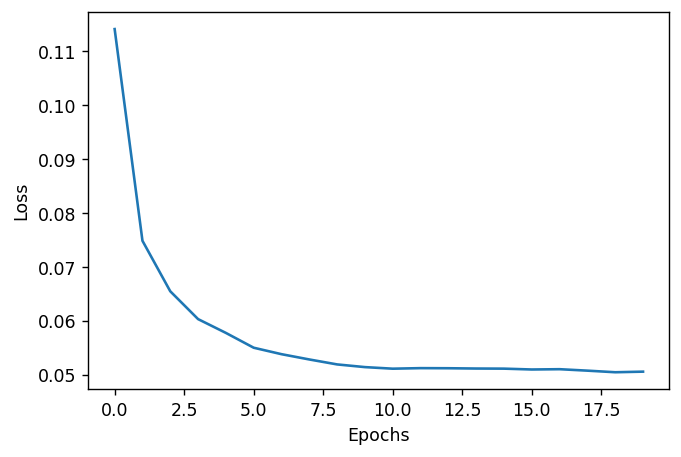

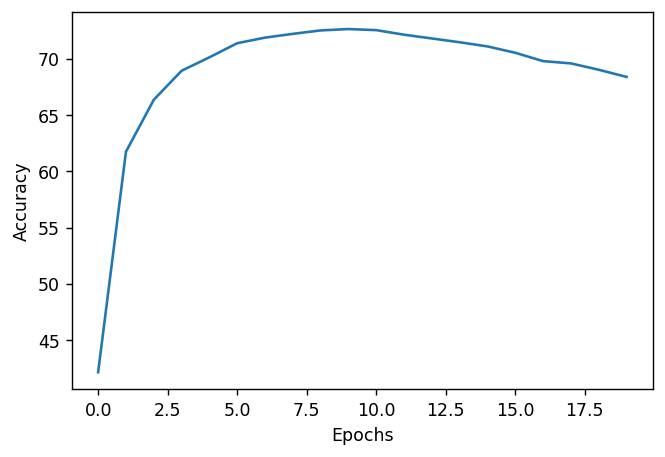

In [13]:
NN.plot()
NN.acc_plot()

In [14]:
NN.predict(X_test,y_test)

Accuracy: 68.21000000000001 %



### 6. Operationalizing Predictions
## Conclusion, Next Steps